In [19]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pandas as pd
import os
import json
import scipy.stats as spst

DATADIR="/storage/mgymrek/chipmunk_round2/fig1_eval"
PDFDIR="/storage/mgymrek/chipmunk_round2/pdfs"

Populating the interactive namespace from numpy and matplotlib


In [20]:
#factor = "GM12878_CTCF_ENCFF298INA_ENCFF303UAB"
factor = "GM12878_CTCF_ENCFF677ISQ_ENCFF307KRD" # favorite
#factor="GM12878_CTCF_ENCFF598OOE_ENCFF706QLS" # decent
#factor = "GM12878_CTCF_ENCFF124LLI_ENCFF256QBB" # good, but keeps going up at 1000
#factor="GM12878_CTCF_ENCFF406XWF_ENCFF934NEI" # bad
#factor="GM12878_CTCF_ENCFF172UCS_ENCFF559IXF" # ok
binsize = 1
use_nc = 1000

# Correlation plot chipmunk vs. encode

Overlap: (0.9164581484225426, 0.0)
No overlap: (0.04797280469773195, 1.268366099618183e-26)
All: (0.5686320645934857, 0.0)


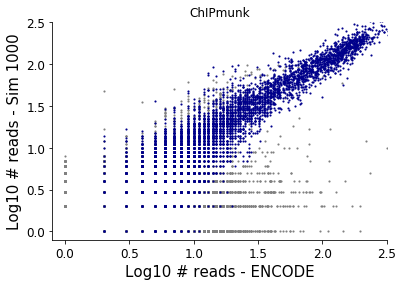

In [21]:
# Assign bins as overlap/not peaks
peakbins = pd.read_csv(os.path.join(DATADIR, factor.strip("_nobam"), "windows_%skb_peak.bed"%binsize), sep="\t", names=["chrom","pos","end"])
peakbins["overlap"] = True
nopeakbins = pd.read_csv(os.path.join(DATADIR, factor.strip("_nobam"), "windows_%skb_nopeak.bed"%binsize), sep="\t", names=["chrom","pos","end"])
nopeakbins["overlap"] = False
binannot = pd.concat([peakbins, nopeakbins]).drop_duplicates()


# Load bin data - chipmunk
enc_bins = pd.read_csv(os.path.join(DATADIR, factor.strip("_nobam"), factor.strip("_nobam")+".ENCODE.cov.%skb.bed"%binsize), usecols=[1,2,3], names=["pos","end","enc.counts"], sep="\t")
sim_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".%s.cov.%skb.bed"%(use_nc, binsize)), usecols=[3], names=["sim.counts"], sep="\t")
bindata = pd.DataFrame({"pos": enc_bins["pos"], "end":enc_bins["end"], \
                        "enc.counts": enc_bins["enc.counts"], \
                        "sim.counts": sim_bins["sim.counts"]})
bindata = bindata[bindata["enc.counts"]+bindata["sim.counts"]>0]
bindata = pd.merge(bindata, binannot, on=["pos","end"])

# Plot
alpha = 1
pc = 1 # pseudocount
fig = plt.figure()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)
ax.scatter(np.log10(bindata[~bindata["overlap"]]["enc.counts"]+pc),
          np.log10(bindata[~bindata["overlap"]]["sim.counts"]+pc),
          color="gray", alpha=alpha, marker=".", s=5)
ax.scatter(np.log10(bindata[bindata["overlap"]]["enc.counts"]+pc),
          np.log10(bindata[bindata["overlap"]]["sim.counts"]+pc),
          color="darkblue", alpha=alpha,  marker=".", s=5)
ax.set_xlim(left=-0.1, right=2.5)
ax.set_ylim(bottom=-0.1, top=2.5)
ax.set_xlabel("Log10 # reads - ENCODE", size=15)
ax.set_ylabel("Log10 # reads - Sim %s"%use_nc, size=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(["%0.1f"%item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%0.1f"%item for item in ax.get_yticks()], size=12);
ax.set_title("ChIPmunk")
#fig.savefig(os.path.join(PDFDIR, "Fig1f_BinsExample_vsNC_scatter_H3K27ac.pdf"))

# Print corr
for b in [bindata]:
    peakbins_corr = (spst.pearsonr(np.log10(b[b["overlap"]]["enc.counts"]+pc), np.log10(b[b["overlap"]]["sim.counts"]+pc)))
    nopeakbins_corr = (spst.pearsonr(np.log10(b[~b["overlap"]]["enc.counts"]+pc), np.log10(b[~b["overlap"]]["sim.counts"]+pc)))
    all_corr = (spst.pearsonr(np.log10(b["enc.counts"]+pc), np.log10(b["sim.counts"]+pc)))

    print("Overlap: %s"%str(peakbins_corr))
    print("No overlap: %s"%str(nopeakbins_corr))
    print("All: %s"%str(all_corr))

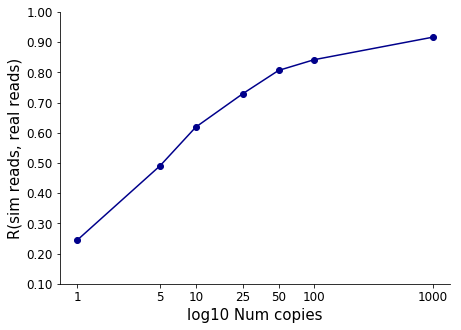

In [22]:
#### get corr for different cell nums
enc_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".ENCODE.cov.%skb.bed"%binsize), usecols=[1,2,3], names=["pos","end","enc.counts"], sep="\t")

ncs = [1, 5, 10, 25, 50, 100, 1000]
rvals_peak = []
for nc in ncs:
    sim_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".%s.cov.%skb.bed"%(nc, binsize)), usecols=[3], names=["sim.counts"], sep="\t")
    bindata = pd.DataFrame({"pos": enc_bins["pos"], "end": enc_bins["end"], 
                            "enc.counts": enc_bins["enc.counts"], "sim.counts": sim_bins["sim.counts"]})
    bindata = bindata[bindata["enc.counts"]+bindata["sim.counts"]>0]
    bindata = pd.merge(bindata, binannot, on=["pos","end"])

    # separate by overlap/no overlap peaks  
    r_peak = spst.pearsonr(np.log10((bindata[bindata["overlap"]]["enc.counts"])+pc), np.log10(bindata[bindata["overlap"]]["sim.counts"]+pc))[0]
    rvals_peak.append(r_peak)

fig = plt.figure()
fig.set_size_inches((7, 5))
ax = fig.add_subplot(111)
ax.plot(np.log10(ncs), rvals_peak, marker="o", color="darkblue");
ax.set_xlabel("log10 Num copies", size=15)
ax.set_ylabel("R(sim reads, real reads)", size=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
if "H3K27ac" in factor:
    ax.set_ylim(bottom=0.8, top=1.0)
else:
    ax.set_ylim(bottom=0.1, top=1.0)
ax.set_xticks(np.log10(ncs))
ax.set_xticklabels(ncs, size=12)
ax.set_yticklabels(["%0.2f"%item for item in ax.get_yticks()], size=12);
#fig.savefig(os.path.join(PDFDIR, "Fig1g_BinsExample_vsNC_H3K27ac.pdf"))